In [1]:
import json
import os
import random
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from nnsight import CONFIG, LanguageModel
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import (
    error_detection,
    get_answer_lookback_payload,
    get_answer_lookback_pointer,
    get_binding_addr_and_payload,
    get_query_charac_oi,
    get_query_object_oi,
)

current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(current_dir)))
from src.dataset import STORY_TEMPLATES, Dataset, Sample
from src import env_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

CONFIG.APP.REMOTE_LOGGING = True

os.environ["NDIF_KEY"] = env_utils.load_env_var("NDIF_KEY")
os.environ["HF_TOKEN"] = env_utils.load_env_var("HF_WRITE")

# Loading Synthetic Data

In [2]:
all_characters = json.load(
    open(
        os.path.join(
            env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "characters.json"
        ),
        "r",
    )
)
all_objects = json.load(
    open(
        os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "bottles.json"),
        "r",
    )
)
all_states = json.load(
    open(
        os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "drinks.json"),
        "r",
    )
)

print(f"#characters: {len(all_characters)}")
print(f"#objects: {len(all_objects)}")
print(f"#states: {len(all_states)}")

#characters: 103
#objects: 21
#states: 23


# Loading model

In [3]:
is_remote = False

if is_remote:
    model = LanguageModel("meta-llama/Meta-Llama-3.1-405B-Instruct")
else:
    model = LanguageModel(
        "meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        torch_dtype=torch.float16,
        dispatch=True,
    )

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

# Evaluating model

In [4]:
n_samples = 100
batch_size = 1

configs, samples = [], []
template_idx = 2
for _ in range(n_samples):
    template = STORY_TEMPLATES["templates"][template_idx]
    characters = random.sample(all_characters, 2)
    containers = random.sample(all_objects, 2)
    states = random.sample(all_states, 2)

    sample = Sample(
        template_idx=template_idx,
        characters=characters,
        containers=containers,
        states=states,
    )
    configs.append(sample)

dataset = Dataset(configs)

for i in range(n_samples):
    sample = dataset.__getitem__(i)
    samples.append(sample)

dataloader = DataLoader(samples, batch_size=1, shuffle=False)


In [5]:
correct, total = 0, 0

with torch.no_grad():
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        prompt = batch["prompt"][0]
        target = batch["target"][0]

        with model.trace(prompt, remote=is_remote):
            pred = model.lm_head.output[0, -1].argmax(dim=-1).item().save()

        # print(
        #     f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}"
        # )
        if model.tokenizer.decode([pred]).lower().strip() == target:
            correct += 1
        total += 1

        del pred
        torch.cuda.empty_cache()

print(f"Accuracy: {round(correct / total, 2)}")

100%|██████████| 100/100 [00:25<00:00,  3.99it/s]

Accuracy: 0.95


# Binding Lookback

## Address and Payload

In [4]:
n_samples = 20
batch_size = 1

dataset = get_binding_addr_and_payload(
    all_characters, all_objects, all_states, n_samples
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [26]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Karen and Max are working in a busy restaurant. To complete an order, Karen grabs an opaque dispenser and fills it with water. Then Max grabs another opaque tun and fills it with port.
Question: What does Karen believe the dispenser contains?
Answer: water
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when

In [6]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


In [21]:
accs_binding_addr_and_payload = {}
patch_layers = (
    [i for i in range(0, 30, 10)]
    + [i for i in range(30, 42, 2)]
    + [i for i in range(50, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]
        input_tokens = model.tokenizer(clean_prompt, return_tensors="pt").input_ids

        state_indices = [155, 156, 167, 168]
        reversed_state_indices = [167, 168, 155, 156]

        corrupt_layer_out = defaultdict(dict)
        with torch.no_grad():
            with model.trace() as tracer:
                with tracer.invoke(corrupt_prompt):
                    for i, token_idx in enumerate(state_indices):
                        corrupt_layer_out[i] = (
                            model.model.layers[layer_idx].output[0][0, token_idx].save()
                        )

                with tracer.invoke(clean_prompt):
                    for i, token_idx in enumerate(reversed_state_indices):
                        model.model.layers[layer_idx].output[0][0, token_idx] = (
                            corrupt_layer_out[i]
                        )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del corrupt_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_binding_addr_and_payload[layer_idx] = acc

100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 20 | Accuracy: 0.0


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 30 | Accuracy: 0.3


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 32 | Accuracy: 0.5


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 34 | Accuracy: 1.0


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 36 | Accuracy: 0.75


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 38 | Accuracy: 0.7


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 40 | Accuracy: 0.15


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 50 | Accuracy: 0.05


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Layer: 60 | Accuracy: 0.0


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]

Layer: 70 | Accuracy: 0.0


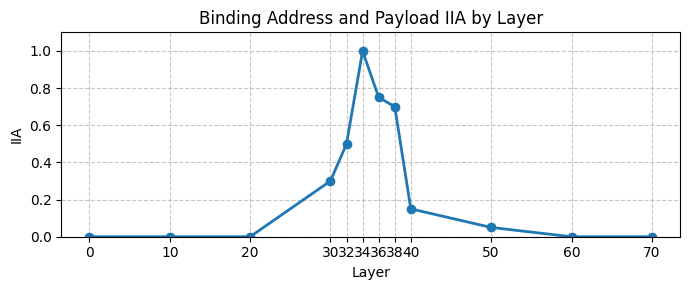

In [ ]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_binding_addr_and_payload.keys())
accuracies = list(accs_binding_addr_and_payload.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Binding Address and Payload IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Source

In [ ]:
n_samples = 20
batch_size = 1

dataset = get_answer_lookback_pointer(
    all_characters, all_objects, all_states, n_samples
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Karen and Max are working in a busy restaurant. To complete an order, Karen grabs an opaque dispenser and fills it with coffee. Then Max grabs another opaque tun and fills it with cocoa.
Question: What does Karen believe the dispenser contains?
Answer: coffee
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only w

In [6]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


### Frozen address and payload of Binding lookback (Fig. 5 in the paper)

In [9]:
accs_source_1 = {}
patch_layers = (
    [i for i in range(0, 20, 10)]
    + [i for i in range(20, 42, 2)]
    + [i for i in range(50, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]
        input_tokens = model.tokenizer(clean_prompt, return_tensors="pt").input_ids

        charac_indices = [131, 133, 146, 147, 158, 159]
        object_indices = [150, 151, 162, 163]
        state_indices = [155, 156, 167, 168]
        reversed_charac_indices = [133, 131, 158, 159, 146, 147]
        reversed_obj_indices = [162, 163, 150, 151]
        reversed_state_indices = [167, 168, 155, 156]

        corrupt_layer_out, clean_layer_out = defaultdict(dict), defaultdict(dict)
        with torch.no_grad():
            with model.trace() as tracer:
                with tracer.invoke(corrupt_prompt):
                    for l in range(layer_idx + 1):
                        for i, token_idx in enumerate(charac_indices + object_indices):
                            corrupt_layer_out[l][i] = (
                                model.model.layers[l].output[0][0, token_idx].save()
                            )

                with tracer.invoke(clean_prompt):
                    for l in range(model.config.num_hidden_layers):
                        for i, token_idx in enumerate(state_indices):
                            clean_layer_out[l][i] = (
                                model.model.layers[l].output[0][0, token_idx].save()
                            )

                with tracer.invoke(clean_prompt):
                    for l in range(layer_idx + 1):
                        for i, token_idx in enumerate(
                            reversed_charac_indices + reversed_obj_indices
                        ):
                            model.model.layers[l].output[0][0, token_idx] = (
                                corrupt_layer_out[l][i]
                            )

                    for l in range(model.config.num_hidden_layers):
                        for i, token_idx in enumerate(state_indices):
                            model.model.layers[l].output[0][0, token_idx] = (
                                clean_layer_out[l][i]
                            )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del corrupt_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_source_1[layer_idx] = acc

100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Layer: 20 | Accuracy: 0.8


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Layer: 22 | Accuracy: 0.8


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Layer: 24 | Accuracy: 0.85


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Layer: 26 | Accuracy: 0.85


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Layer: 28 | Accuracy: 0.9


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Layer: 30 | Accuracy: 0.9


100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Layer: 32 | Accuracy: 0.95


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Layer: 34 | Accuracy: 0.95


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Layer: 36 | Accuracy: 0.75


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Layer: 38 | Accuracy: 0.65


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Layer: 40 | Accuracy: 0.45


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Layer: 50 | Accuracy: 0.4


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Layer: 60 | Accuracy: 0.4


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]

Layer: 70 | Accuracy: 0.35


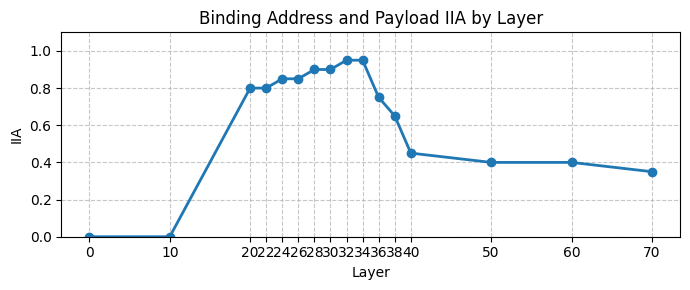

In [10]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_source_1.keys())
accuracies = list(accs_source_1.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Binding Source IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

### Without freezing the address and payload of Binding lookback (Fig.12 in the paper)

In [11]:
accs_source_2 = {}
patch_layers = (
    [i for i in range(0, 20, 10)]
    + [i for i in range(20, 42, 2)]
    + [i for i in range(50, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]
        input_tokens = model.tokenizer(clean_prompt, return_tensors="pt").input_ids

        charac_indices = [131, 133, 146, 147, 158, 159]
        object_indices = [150, 151, 162, 163]
        state_indices = [155, 156, 167, 168]
        reversed_charac_indices = [133, 131, 158, 159, 146, 147]
        reversed_obj_indices = [162, 163, 150, 151]
        reversed_state_indices = [167, 168, 155, 156]

        corrupt_layer_out = defaultdict(dict)
        with torch.no_grad():
            with model.trace() as tracer:
                with tracer.invoke(corrupt_prompt):
                    for l in range(layer_idx + 1):
                        for i, token_idx in enumerate(charac_indices + object_indices):
                            corrupt_layer_out[l][i] = (
                                model.model.layers[l].output[0][0, token_idx].save()
                            )

                with tracer.invoke(clean_prompt):
                    for l in range(layer_idx + 1):
                        for i, token_idx in enumerate(
                            reversed_charac_indices + reversed_obj_indices
                        ):
                            model.model.layers[l].output[0][0, token_idx] = (
                                corrupt_layer_out[l][i]
                            )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del corrupt_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_source_2[layer_idx] = acc

100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Layer: 20 | Accuracy: 0.2


100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Layer: 22 | Accuracy: 0.25


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Layer: 24 | Accuracy: 0.25


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Layer: 26 | Accuracy: 0.2


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


Layer: 28 | Accuracy: 0.25


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Layer: 30 | Accuracy: 0.25


100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Layer: 32 | Accuracy: 0.35


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Layer: 34 | Accuracy: 0.35


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Layer: 36 | Accuracy: 0.35


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Layer: 38 | Accuracy: 0.35


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Layer: 40 | Accuracy: 0.35


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Layer: 50 | Accuracy: 0.35


100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Layer: 60 | Accuracy: 0.35


100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

Layer: 70 | Accuracy: 0.35


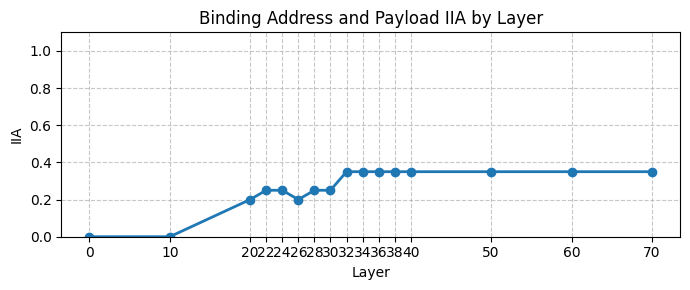

In [12]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_source_2.keys())
accuracies = list(accs_source_2.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Binding Source IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Pointer (Query Character OI)

In [12]:
n_samples = 20
batch_size = 1

dataset = get_query_charac_oi(all_characters, all_objects, all_states, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [13]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Ruth and Jean are working in a busy restaurant. To complete an order, Ruth grabs an opaque can and fills it with espresso. Then Jean grabs another opaque pint and fills it with wine.
Question: What does Ruth believe the can contains?
Answer: espresso
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they 

In [14]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


In [16]:
accs_query_charac_oi = {}
patch_layers = (
    [i for i in range(0, 20, 10)]
    + [i for i in range(20, 42, 2)]
    + [i for i in range(50, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        corrupt_layer_out, clean_state_out = defaultdict(dict), defaultdict(dict)
        with model.session():
            with model.trace() as tracer:
                with tracer.invoke(corrupt_prompt):
                    for token_idx in [-8, -7]:
                        corrupt_layer_out[token_idx] = model.model.layers[
                            layer_idx
                        ].output[0][0, token_idx]

                with tracer.invoke(clean_prompt):
                    for token_idx in [-8, -7]:
                        model.model.layers[layer_idx].output[0][0, token_idx] = (
                            corrupt_layer_out[token_idx]
                        )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        # print(f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}")
        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del corrupt_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_query_charac_oi[layer_idx] = acc

100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Layer: 20 | Accuracy: 0.83


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Layer: 22 | Accuracy: 0.78


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Layer: 24 | Accuracy: 0.78


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Layer: 26 | Accuracy: 0.78


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Layer: 28 | Accuracy: 0.61


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Layer: 30 | Accuracy: 0.44


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Layer: 32 | Accuracy: 0.11


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Layer: 34 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Layer: 36 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Layer: 38 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Layer: 40 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Layer: 50 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Layer: 60 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]

Layer: 70 | Accuracy: 0.0


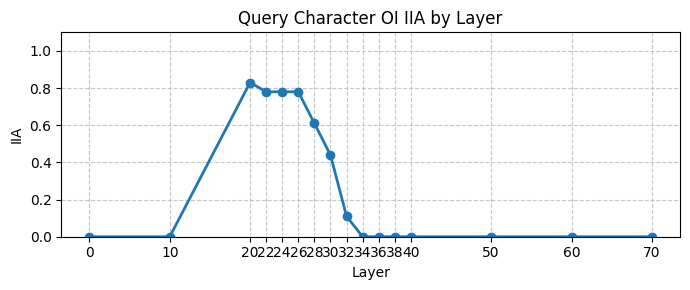

In [17]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_query_charac_oi.keys())
accuracies = list(accs_query_charac_oi.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Query Character OI IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Pointer (Query Object OI)

In [8]:
n_samples = 20
batch_size = 1

dataset = get_query_object_oi(all_characters, all_objects, all_states, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [9]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Carl and Bob are working in a busy restaurant. To complete an order, Carl grabs an opaque tank and fills it with juice. Then Bob grabs another opaque tote and fills it with ale.
Question: What does Carl believe the tank contains?
Answer: juice
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform

In [10]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


In [13]:
accs_query_object_oi = {}
patch_layers = (
    [i for i in range(0, 20, 10)]
    + [i for i in range(20, 42, 2)]
    + [i for i in range(50, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        corrupt_layer_out, clean_state_out = defaultdict(dict), defaultdict(dict)
        with model.session():
            with model.trace() as tracer:
                with tracer.invoke(corrupt_prompt):
                    for token_idx in [-5, -4]:
                        corrupt_layer_out[token_idx] = model.model.layers[
                            layer_idx
                        ].output[0][0, token_idx]

                with tracer.invoke(clean_prompt):
                    for token_idx in [-5, -4]:
                        model.model.layers[layer_idx].output[0][0, token_idx] = (
                            corrupt_layer_out[token_idx]
                        )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        # print(f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}")
        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del corrupt_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_query_object_oi[layer_idx] = acc

100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Layer: 20 | Accuracy: 0.84


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Layer: 22 | Accuracy: 0.84


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Layer: 24 | Accuracy: 0.79


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 26 | Accuracy: 0.79


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Layer: 28 | Accuracy: 0.68


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Layer: 30 | Accuracy: 0.26


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 32 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 34 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Layer: 36 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Layer: 38 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Layer: 40 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Layer: 50 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Layer: 60 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]

Layer: 70 | Accuracy: 0.0


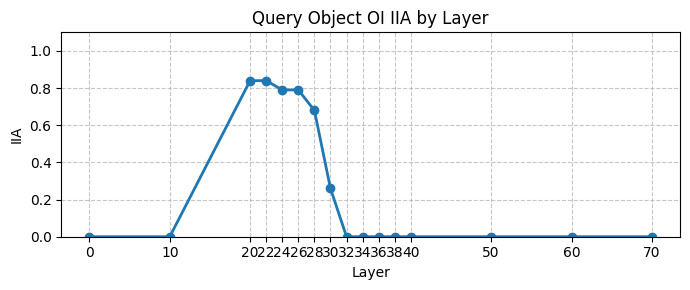

In [14]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_query_object_oi.keys())
accuracies = list(accs_query_object_oi.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Query Object OI IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Answer Lookback

## Pointer

In [15]:
n_samples = 20
batch_size = 1

dataset = get_answer_lookback_pointer(
    all_characters,
    all_objects,
    all_states,
    n_samples,
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [16]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Mark and Charlie are working in a busy restaurant. To complete an order, Mark grabs an opaque pitcher and fills it with punch. Then Charlie grabs another opaque quart and fills it with float.
Question: What does Charlie believe the quart contains?
Answer: float
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only

In [17]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


In [18]:
accs_answer_lookback_pointer = {}
patch_layers = (
    [i for i in range(0, 30, 10)]
    + [i for i in range(32, 62, 2)]
    + [i for i in range(70, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        with model.session():
            with model.trace() as tracer:
                with tracer.invoke(corrupt_prompt):
                    corrupt_layer_out = model.model.layers[layer_idx].output[0][0, -1]

                with tracer.invoke(clean_prompt):
                    model.model.layers[layer_idx].output[0][0, -1] = corrupt_layer_out
                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del corrupt_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_answer_lookback_pointer[layer_idx] = acc

100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 20 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 32 | Accuracy: 0.1


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Layer: 34 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 36 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Layer: 38 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 40 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Layer: 42 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Layer: 44 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Layer: 46 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Layer: 48 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 50 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 52 | Accuracy: 0.85


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Layer: 54 | Accuracy: 0.45


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 56 | Accuracy: 0.1


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 58 | Accuracy: 0.05


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Layer: 60 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

Layer: 70 | Accuracy: 0.0


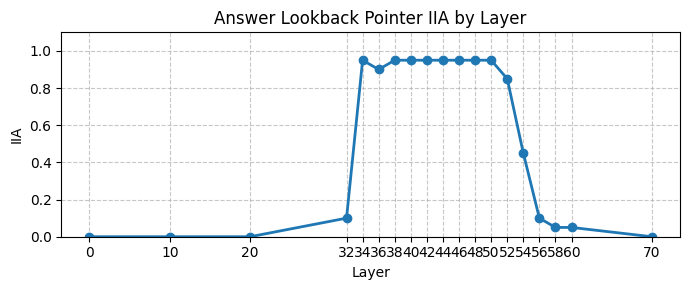

In [19]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_answer_lookback_pointer.keys())
accuracies = list(accs_answer_lookback_pointer.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Answer Lookback Pointer IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Payload

In [4]:
n_samples = 20
batch_size = 1

dataset = get_answer_lookback_payload(
    all_characters,
    all_objects,
    all_states,
    n_samples,
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Tony and Nancy are working in a busy restaurant. To complete an order, Tony grabs an opaque dispenser and fills it with stout. Then Nancy grabs another opaque can and fills it with juice.
Question: What does Nancy believe the can contains?
Answer: juice
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when th

In [6]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


In [7]:
accs_answer_lookback_payload = {}
patch_layers = [i for i in range(0, 60, 10)] + [
    i for i in range(52, model.config.num_hidden_layers, 2)
]

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        with model.session():
            with model.trace() as tracer:
                with tracer.invoke(corrupt_prompt):
                    corrupt_layer_out = model.model.layers[layer_idx].output[0][0, -1]

                with tracer.invoke(clean_prompt):
                    model.model.layers[layer_idx].output[0][0, -1] = corrupt_layer_out
                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del corrupt_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_answer_lookback_payload[layer_idx] = acc

100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 20 | Accuracy: 0.0


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 30 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Layer: 40 | Accuracy: 0.05


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 50 | Accuracy: 0.05


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 52 | Accuracy: 0.05


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 54 | Accuracy: 0.37


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Layer: 56 | Accuracy: 0.89


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 58 | Accuracy: 0.95


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 60 | Accuracy: 1.0


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 62 | Accuracy: 1.0


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Layer: 64 | Accuracy: 1.0


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 66 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Layer: 68 | Accuracy: 1.0


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 70 | Accuracy: 1.0


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 72 | Accuracy: 1.0


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 74 | Accuracy: 1.0


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Layer: 76 | Accuracy: 1.0


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]

Layer: 78 | Accuracy: 1.0


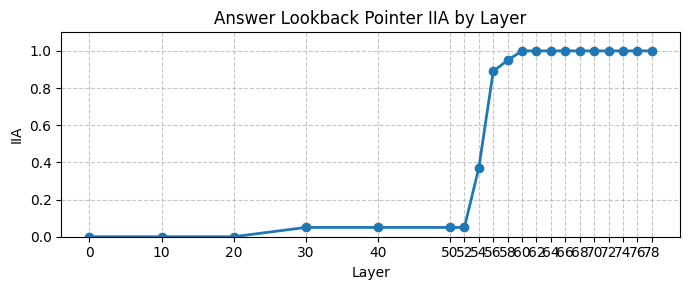

In [8]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_answer_lookback_payload.keys())
accuracies = list(accs_answer_lookback_payload.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Answer Lookback Pointer IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()